<div style="
    max-width: 900px;
    margin: 20px auto;
    padding: 22px 26px;
    border-radius: 14px;
    background: linear-gradient(180deg, #f9fafb 0%, #f3f4f6 100%);
    border-left: 6px solid #3b82f6;
    box-shadow: 0 6px 18px rgba(0,0,0,0.08);
    font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif;
    font-size: 1.05rem;
    line-height: 1.65;
    color: #1f2937;
    white-space: pre-wrap;">

<h2 style="color:#2563eb; margin-top:0; font-weight:600;">Background</h2>

Thanks to technological advances, animal geneticists have an ever-expanding tool chest with which to
study the inheritance of traits in <span style="background:#dbeafe; padding:2px 6px; border-radius:4px;">livestock</span> in order to improve production.  
With the rise of <span style="background:#fef3c7; padding:2px 6px; border-radius:4px;">high-throughput technology</span>, vast amounts of 
<span style="background:#dcfce7; padding:2px 6px; border-radius:4px;">genotype/phenotype data</span> are being rapidly generated.  

<span style="background:#e0e7ff; padding:2px 6px; border-radius:4px;">Animal QTLdb</span> and other genotype/phenotype databases would greatly benefit from 
<span style="background:#fbcfe8; padding:2px 6px; border-radius:4px;">automated and expedited curation</span> tools.  

While the adoption of <span style="background:#fde68a; padding:2px 6px; border-radius:4px;">controlled vocabularies</span> and 
<span style="background:#fef9c3; padding:2px 6px; border-radius:4px;">ontologies</span> is well recognized for facilitating data integration and reuse, 
it is nontrivial to <span style="background:#fca5a5; padding:2px 6px; border-radius:4px;">automatically extract terms</span> from scientific texts.  

---

<b>In this project</b>, we want to <span style="background:#bbf7d0; padding:2px 6px; border-radius:4px;">analyze the terminologies</span> used in the collected corpus 
and <span style="background:#bae6fd; padding:2px 6px; border-radius:4px;">understand the trend of studies</span>.
</div>


In [1]:
print(1)


1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json,re

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
try:
    nltk.download("punkt_tab", quiet=True)
except Exception:
    print("COuldn't download")
    pass
nltk.download("stopwords", quiet=True)

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Utilities

**Visualize Abstracts**

In [3]:
from textwrap import fill
import shutil, html
from pathlib import Path

def display_abstract_cards(df, n=5):
    """
    Render the first `n` abstracts as tidy HTML cards (in Jupyter).
    """
    from IPython.display import display, HTML

    css = """
    <style>
      .abs-wrap { font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; }
      .abs-card {
        border: 1px solid #e5e7eb; border-radius: 12px; padding: 14px 16px; margin: 10px 0;
        box-shadow: 0 1px 2px rgba(0,0,0,0.04);
      }
      .abs-title { font-size: 1.05rem; font-weight: 600; margin: 0 0 6px 0; line-height: 1.35; }
      .abs-meta { font-size: 0.9rem; opacity: 0.8; margin-bottom: 8px; }
      .badge { display: inline-block; font-size: 0.75rem; padding: 2px 8px; border-radius: 999px;
               border: 1px solid #d1d5db; margin-left: 6px; }
      .abs-abstract { white-space: pre-wrap; line-height: 1.5; }
    </style>
    """

    cards = []
    for _, r in df.head(n).iterrows():
        title = html.escape(str(r.get("Title", "")))
        journal = html.escape(str(r.get("Journal", "")))
        pmid = html.escape(str(r.get("PMID", "")))
        cat = html.escape(str(r.get("Category", "")))
        abstract = html.escape(str(r.get("Abstract", "")))
        card = f"""
        <div class="abs-card">
          <div class="abs-title">{title}</div>
          <div class="abs-meta">
            <span><strong>PMID:</strong> {pmid}</span> &nbsp;•&nbsp;
            <span><strong>Journal:</strong> {journal}</span>
            <span class="badge">Category {cat}</span>
          </div>
          <div class="abs-abstract">{abstract}</div>
        </div>
        """
        cards.append(card)

    html_out = f'<div class="abs-wrap">{css}' + "\n".join(cards) + "</div>"
    display(HTML(html_out))

# Load Files

In [4]:
base_path = "/kaggle/input/project1-data/"
json_path = base_path+"QTL_text.json"
dictionary_path = base_path+"Trait_dictionary.txt"

In [5]:
import pandas as pd

full_data = pd.read_json(json_path)

full_data.head()

,PMID,Journal,Title,Abstract,Category
0,17179536,J Anim Sci. 2007 Jan;85(1):22-30.,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1
1,17177700,J Anim Breed Genet. 2006 Dec;123(6):414-8.,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0
2,17129674,Vet Parasitol. 2007 Apr 10;145(1-2):2-10. Epub...,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0
3,17121599,Anim Genet. 2006 Dec;37(6):543-53.,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1
4,17057239,Genetics. 2006 Dec;174(4):2119-27. Epub 2006 O...,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0


In [6]:
display_abstract_cards(full_data,n=3)

In [7]:
with open(dictionary_path,'r') as f:
    dictionary = f.readlines()
dictionary[:5]

['% change in Hct\n',
 '(WHR)\n',
 '(total protein minus albumin)\n',
 '3-methyl indole\n',
 '3-methyl indole concentration\n']

# EDA

In [8]:
full_data.head()

,PMID,Journal,Title,Abstract,Category
0,17179536,J Anim Sci. 2007 Jan;85(1):22-30.,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1
1,17177700,J Anim Breed Genet. 2006 Dec;123(6):414-8.,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0
2,17129674,Vet Parasitol. 2007 Apr 10;145(1-2):2-10. Epub...,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0
3,17121599,Anim Genet. 2006 Dec;37(6):543-53.,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1
4,17057239,Genetics. 2006 Dec;174(4):2119-27. Epub 2006 O...,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0


In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11278 entries, 0 to 11277
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PMID      11278 non-null  int64 
 1   Journal   11278 non-null  object
 2   Title     11278 non-null  object
 3   Abstract  11278 non-null  object
 4   Category  11278 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 440.7+ KB


In [10]:
full_data.Category.value_counts()

Category
0    10271
1     1007
Name: count, dtype: int64

In [11]:
full_data.nunique()

PMID        11260
Journal     11260
Title       11232
Abstract    11259
Category        2
dtype: int64

In [12]:
data = full_data[["Abstract","Category"]]
data = data[data["Category"]==1]
data['text_length'] = data['Abstract'].apply(lambda x : len(x.split()))
data.head()

,Abstract,Category,text_length
0,"In a previous study, QTL for carcass compositi...",1,215
3,A whole-genome quantitative trait locus (QTL) ...,1,137
5,A partial genome scan using microsatellite mar...,1,168
7,BACKGROUND: The rate of pubertal development a...,1,384
10,"Previously, quantitative trait loci (QTL) for ...",1,200


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


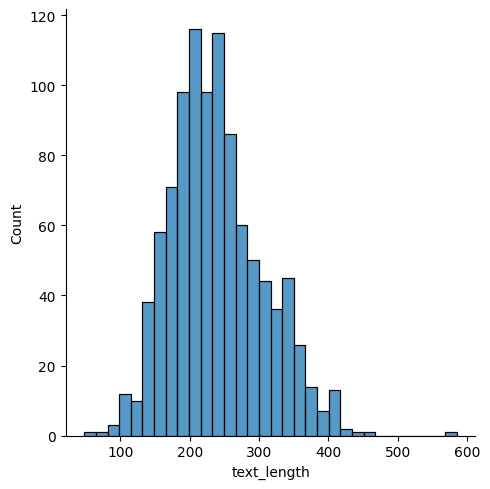

In [13]:
sns.displot(data['text_length'])

# Step 0 : Preprocessing

> You will need to preprocess the text with 0) collect all abstracts with Category:1, 1) split sentences and
tokenize, 2) convert to lower case, and 3) remove stop words.
You can use any existing libraries/implementations for this project. 

**With nltk**

In [14]:
def flatten(L):
    out = []
    for s in L:
        out.extend(s)
    return out

In [15]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [16]:
from string import punctuation

def _ensure_str(x):
    return "" if (x is None or (isinstance(x, float) and pd.isna(x))) else str(x)


def nltk_process(text: str):
    txt = _ensure_str(text)
    sents = sent_tokenize(txt)
    sw = stopwords.words("english")
    sw_and_puncts = set(list(sw)+list(punctuation))
    toks_by_sent = []
    for s in sents:
        toks = [w.lower() for w in word_tokenize(s) if w.lower() not in sw_and_puncts and not is_number(w) and len(w)>1]
        toks_by_sent.append(toks)
    return sents, toks_by_sent

In [17]:
%%time
n_sents_toks = data["Abstract"].apply(nltk_process)
data["nltk_sentences"], data["nltk_tokens_by_sentence"] = zip(*n_sents_toks)
data["nltk_all_tokens"] = data["nltk_tokens_by_sentence"].apply(lambda x: flatten(x))

CPU times: user 2.03 s, sys: 56.3 ms, total: 2.09 s
Wall time: 2.09 s


In [18]:
data.head()

,Abstract,Category,text_length,nltk_sentences,nltk_tokens_by_sentence,nltk_all_tokens
0,"In a previous study, QTL for carcass compositi...",1,215,"[In a previous study, QTL for carcass composit...","[[previous, study, qtl, carcass, composition, ...","[previous, study, qtl, carcass, composition, m..."
3,A whole-genome quantitative trait locus (QTL) ...,1,137,[A whole-genome quantitative trait locus (QTL)...,"[[whole-genome, quantitative, trait, locus, qt...","[whole-genome, quantitative, trait, locus, qtl..."
5,A partial genome scan using microsatellite mar...,1,168,[A partial genome scan using microsatellite ma...,"[[partial, genome, scan, using, microsatellite...","[partial, genome, scan, using, microsatellite,..."
7,BACKGROUND: The rate of pubertal development a...,1,384,[BACKGROUND: The rate of pubertal development ...,"[[background, rate, pubertal, development, wea...","[background, rate, pubertal, development, wean..."
10,"Previously, quantitative trait loci (QTL) for ...",1,200,"[Previously, quantitative trait loci (QTL) for...","[[previously, quantitative, trait, loci, qtl, ...","[previously, quantitative, trait, loci, qtl, t..."


In [19]:
from IPython.display import display, Markdown

def show_row(df, n, cols=None):
    """
    Display the nth row of a DataFrame in a collapsible HTML card.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe.
    n : int
        Row index.
    cols : list of str, optional
        Columns to display. If None, all columns except 'text_length' and 'Category' are shown.
    """
    row = df.iloc[n]

    if cols is None:
        cols = [c for c in df.columns if c not in ("text_length", "Category")]

    # Build HTML for each column dynamically
    parts = []
    colors = ["#2563eb", "#16a34a", "#9333ea", "#dc2626", "#ea580c", "#0891b2"]  # cycle colors
    for i, col in enumerate(cols):
        color = colors[i % len(colors)]
        parts.append(f"<h3 style='color:{color}; margin-top:0;'>{col}</h3><p>{row[col]}</p>")

    md = f"""
<details style="margin:12px;">
  <summary style="font-size:1.1rem; font-weight:600; color:#2563eb; cursor:pointer;">
    ▶ Show Row {n}
  </summary>
  <div style="max-width:850px; margin-top:10px; padding:16px 20px;
              border-radius:12px; background:#f9fafb;
              border:1px solid #e5e7eb; box-shadow:0 2px 8px rgba(0,0,0,0.05);
              font-family:Segoe UI, Roboto, sans-serif; line-height:1.55;">
    {''.join(parts)}
  </div>
</details>
"""
    display(Markdown(md))


show_row(data,75,cols=['Abstract','nltk_sentences',
       'nltk_tokens_by_sentence', 'nltk_all_tokens'])


<details style="margin:12px;">
  <summary style="font-size:1.1rem; font-weight:600; color:#2563eb; cursor:pointer;">
    ▶ Show Row 75
  </summary>
  <div style="max-width:850px; margin-top:10px; padding:16px 20px;
              border-radius:12px; background:#f9fafb;
              border:1px solid #e5e7eb; box-shadow:0 2px 8px rgba(0,0,0,0.05);
              font-family:Segoe UI, Roboto, sans-serif; line-height:1.55;">
    <h3 style='color:#2563eb; margin-top:0;'>Abstract</h3><p>Although susceptibility to scrapie is largely controlled by the PRNP gene, we have searched for additional genomic regions that affect scrapie incubation time  in sheep, using two half-sib families with a susceptible PRNP genotype and naturally infected by scrapie. Quantitative trait loci were detected on OAR6 and  OAR18.</p><h3 style='color:#16a34a; margin-top:0;'>nltk_sentences</h3><p>['Although susceptibility to scrapie is largely controlled by the PRNP gene, we have searched for additional genomic regions that affect scrapie incubation time  in sheep, using two half-sib families with a susceptible PRNP genotype and naturally infected by scrapie.', 'Quantitative trait loci were detected on OAR6 and  OAR18.']</p><h3 style='color:#9333ea; margin-top:0;'>nltk_tokens_by_sentence</h3><p>[['although', 'susceptibility', 'scrapie', 'largely', 'controlled', 'prnp', 'gene', 'searched', 'additional', 'genomic', 'regions', 'affect', 'scrapie', 'incubation', 'time', 'sheep', 'using', 'two', 'half-sib', 'families', 'susceptible', 'prnp', 'genotype', 'naturally', 'infected', 'scrapie'], ['quantitative', 'trait', 'loci', 'detected', 'oar6', 'oar18']]</p><h3 style='color:#dc2626; margin-top:0;'>nltk_all_tokens</h3><p>['although', 'susceptibility', 'scrapie', 'largely', 'controlled', 'prnp', 'gene', 'searched', 'additional', 'genomic', 'regions', 'affect', 'scrapie', 'incubation', 'time', 'sheep', 'using', 'two', 'half-sib', 'families', 'susceptible', 'prnp', 'genotype', 'naturally', 'infected', 'scrapie', 'quantitative', 'trait', 'loci', 'detected', 'oar6', 'oar18']</p>
  </div>
</details>


**Spacy Preprocessing**

In [20]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","ner"])
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

In [21]:
def spacy_process(text: str):
    txt = _ensure_str(text)
    doc = nlp(txt)
    sents = [s.text for s in doc.sents]
    toks_by_sent = []
    for s in sents:
        # fast tokenization without full pipeline work
        toks = [t.text.lower() for t in nlp.make_doc(s) if t.text.lower() not in STOP_WORDS and not t.is_punct and not t.is_space and not is_number(t.text) and len(t.text)>1]
        toks_by_sent.append(toks)
    return sents, toks_by_sent

In [22]:
%%time
text_col = "Abstract"
s_sents_toks = data[text_col].apply(spacy_process)
data["spacy_sentences"], data["spacy_tokens_by_sentence"] = zip(*s_sents_toks)
data["spacy_all_tokens"] = data["spacy_tokens_by_sentence"].apply(lambda x: flatten(x))

CPU times: user 17.6 s, sys: 65.6 ms, total: 17.7 s
Wall time: 17.7 s


In [23]:
show_row(data,75,cols=['Abstract','spacy_sentences',
       'spacy_tokens_by_sentence', 'spacy_all_tokens'])


<details style="margin:12px;">
  <summary style="font-size:1.1rem; font-weight:600; color:#2563eb; cursor:pointer;">
    ▶ Show Row 75
  </summary>
  <div style="max-width:850px; margin-top:10px; padding:16px 20px;
              border-radius:12px; background:#f9fafb;
              border:1px solid #e5e7eb; box-shadow:0 2px 8px rgba(0,0,0,0.05);
              font-family:Segoe UI, Roboto, sans-serif; line-height:1.55;">
    <h3 style='color:#2563eb; margin-top:0;'>Abstract</h3><p>Although susceptibility to scrapie is largely controlled by the PRNP gene, we have searched for additional genomic regions that affect scrapie incubation time  in sheep, using two half-sib families with a susceptible PRNP genotype and naturally infected by scrapie. Quantitative trait loci were detected on OAR6 and  OAR18.</p><h3 style='color:#16a34a; margin-top:0;'>spacy_sentences</h3><p>['Although susceptibility to scrapie is largely controlled by the PRNP gene, we have searched for additional genomic regions that affect scrapie incubation time  in sheep, using two half-sib families with a susceptible PRNP genotype and naturally infected by scrapie.', 'Quantitative trait loci were detected on OAR6 and  OAR18.']</p><h3 style='color:#9333ea; margin-top:0;'>spacy_tokens_by_sentence</h3><p>[['susceptibility', 'scrapie', 'largely', 'controlled', 'prnp', 'gene', 'searched', 'additional', 'genomic', 'regions', 'affect', 'scrapie', 'incubation', 'time', 'sheep', 'half', 'sib', 'families', 'susceptible', 'prnp', 'genotype', 'naturally', 'infected', 'scrapie'], ['quantitative', 'trait', 'loci', 'detected', 'oar6', 'oar18']]</p><h3 style='color:#dc2626; margin-top:0;'>spacy_all_tokens</h3><p>['susceptibility', 'scrapie', 'largely', 'controlled', 'prnp', 'gene', 'searched', 'additional', 'genomic', 'regions', 'affect', 'scrapie', 'incubation', 'time', 'sheep', 'half', 'sib', 'families', 'susceptible', 'prnp', 'genotype', 'naturally', 'infected', 'scrapie', 'quantitative', 'trait', 'loci', 'detected', 'oar6', 'oar18']</p>
  </div>
</details>


In [24]:
data.head()

,Abstract,Category,text_length,nltk_sentences,nltk_tokens_by_sentence,nltk_all_tokens,spacy_sentences,spacy_tokens_by_sentence,spacy_all_tokens
0,"In a previous study, QTL for carcass compositi...",1,215,"[In a previous study, QTL for carcass composit...","[[previous, study, qtl, carcass, composition, ...","[previous, study, qtl, carcass, composition, m...","[In a previous study, QTL for carcass composit...","[[previous, study, qtl, carcass, composition, ...","[previous, study, qtl, carcass, composition, m..."
3,A whole-genome quantitative trait locus (QTL) ...,1,137,[A whole-genome quantitative trait locus (QTL)...,"[[whole-genome, quantitative, trait, locus, qt...","[whole-genome, quantitative, trait, locus, qtl...",[A whole-genome quantitative trait locus (QTL)...,"[[genome, quantitative, trait, locus, qtl, sca...","[genome, quantitative, trait, locus, qtl, scan..."
5,A partial genome scan using microsatellite mar...,1,168,[A partial genome scan using microsatellite ma...,"[[partial, genome, scan, using, microsatellite...","[partial, genome, scan, using, microsatellite,...",[A partial genome scan using microsatellite ma...,"[[partial, genome, scan, microsatellite, marke...","[partial, genome, scan, microsatellite, marker..."
7,BACKGROUND: The rate of pubertal development a...,1,384,[BACKGROUND: The rate of pubertal development ...,"[[background, rate, pubertal, development, wea...","[background, rate, pubertal, development, wean...",[BACKGROUND: The rate of pubertal development ...,"[[background, rate, pubertal, development, wea...","[background, rate, pubertal, development, wean..."
10,"Previously, quantitative trait loci (QTL) for ...",1,200,"[Previously, quantitative trait loci (QTL) for...","[[previously, quantitative, trait, loci, qtl, ...","[previously, quantitative, trait, loci, qtl, t...","[Previously, quantitative trait loci (QTL) for...","[[previously, quantitative, trait, loci, qtl, ...","[previously, quantitative, trait, loci, qtl, t..."


# Task1

> Use wordcloud to visualize words in this corpus. The figure should be 800*800, with white background
color. You will need to generate two word cloud images: 1) use word frequency, and 2) use tf-idf

In [25]:
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def load_tokens(df,option="nltk"):

    col = f"{option}_all_tokens"
    toks = df[col].apply(lambda s: json.loads(s) if isinstance(s, str) else (s or []))
    return toks.tolist()

def _draw_wc(freqdict, outfile, w=800, h=800, bg="white"):
    wc = WordCloud(width=w, height=h, background_color=bg, collocations=False)
    wc = wc.generate_from_frequencies(freqdict)
    wc.to_file(outfile)
    plt.figure(figsize=(w/100, h/100), dpi=100)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
def make_wordclouds(df,option="nltk"):
    docs_tokens = load_tokens(df,option)
    docs = [" ".join(t) for t in docs_tokens]

    # 1) Frequency
    freq = Counter()
    for t in docs_tokens: freq.update(t)
    _draw_wc(freq, f"wordcloud_freq_{option}.png")

    # 2) TF-IDF (sum across docs as global weight)
    vec = TfidfVectorizer()
    X = vec.fit_transform(docs)
    weights = np.asarray(X.sum(axis=0)).ravel()
    vocab = vec.get_feature_names_out()
    tfidf = {term: float(w) for term, w in zip(vocab, weights) if w > 0}
    _draw_wc(tfidf, f"wordcloud_tfidf_{option}.png")

    print(f"Saved: wordcloud_freq_{option}.png, wordcloud_tfidf_{option}.png")


**For NLTK**

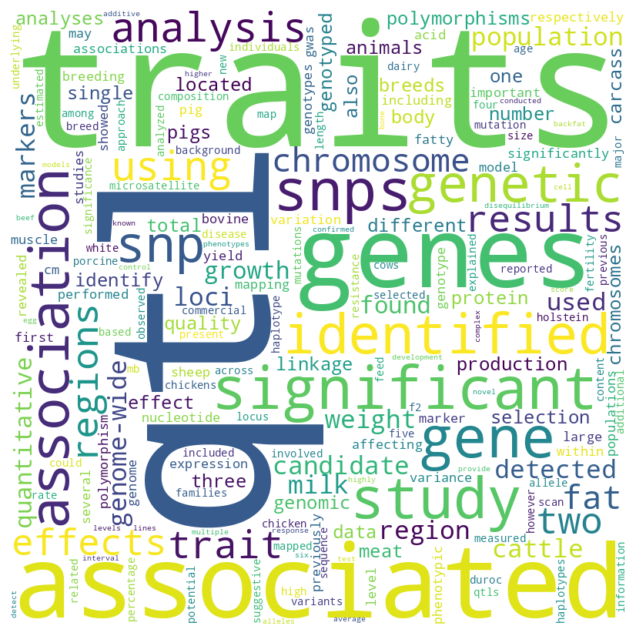

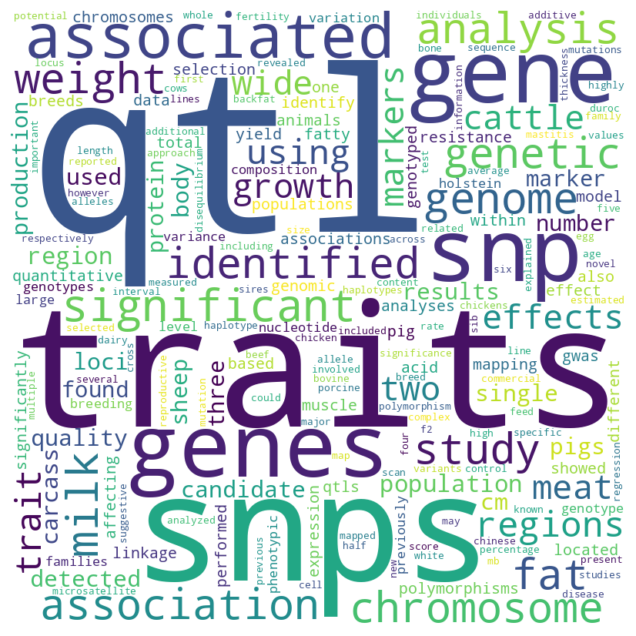

Saved: wordcloud_freq_nltk.png, wordcloud_tfidf_nltk.png


In [26]:
make_wordclouds(data,option="nltk")

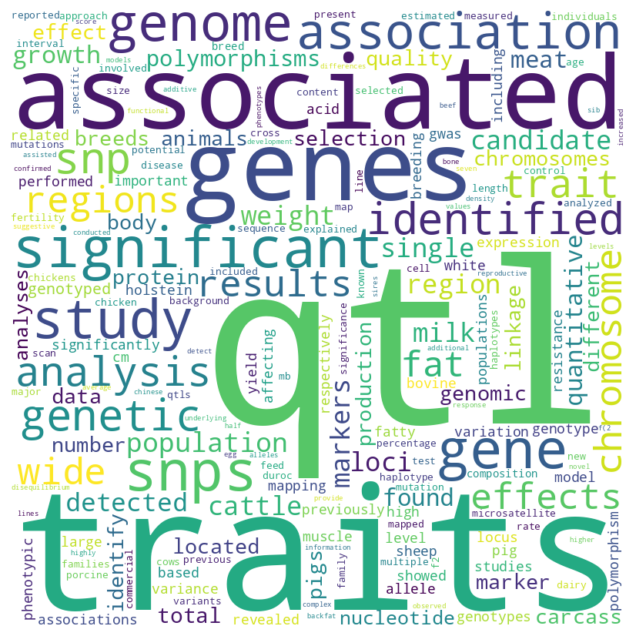

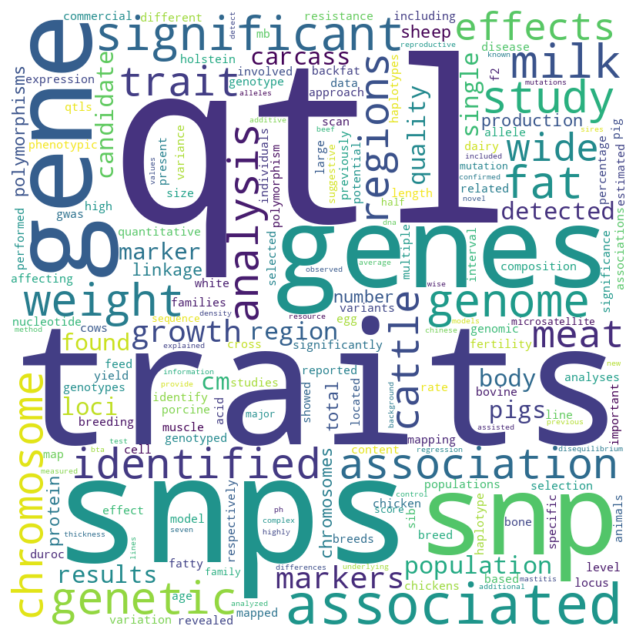

Saved: wordcloud_freq_spacy.png, wordcloud_tfidf_spacy.png


In [27]:
make_wordclouds(data,option="spacy")

# Task 2

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [29]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def viz_w2v_sims(w2v, terms, topn=15, cols=2, option="nltk",heatmap=False,save=True,save_text=True):
    """
    Visualize Word2Vec most-similar words for given terms.
    - w2v: trained gensim Word2Vec model
    - terms: list of query terms (e.g., top TF-IDF terms)
    - topn: number of neighbours to show per term
    - cols: columns for small-multiples grid
    - heatmap: if True, also renders a (terms x neighbours) heatmap
    Returns a tidy DataFrame with columns: term, similar, sim
    """
    out_prefix = f"{option}_task2"
    rows = []
    for t in terms:
        if t in w2v.wv.key_to_index:
            for w, s in w2v.wv.most_similar(t, topn=topn):
                rows.append((t, w, s))
        else:
            rows.append((t, "(not in vocab)", np.nan))

    df = pd.DataFrame(rows, columns=["term","similar","sim"])

    # --- Small multiples ---
    uniq = [t for t in terms if t in w2v.wv.key_to_index] or ["(none)"]
    r = int(np.ceil(len(uniq)/cols))
    plt.figure(figsize=(6*cols, 2.8*r))
    for i, t in enumerate(uniq, 1):
        ax = plt.subplot(r, cols, i)
        d = df[df.term==t].nlargest(topn, "sim")
        ax.barh(d["similar"][::-1], d["sim"][::-1])      # default matplotlib colors
        ax.set_title(t)
        ax.set_xlim(0, 1)
        ax.tick_params(axis="both", labelsize=8)
    plt.tight_layout(); plt.show()
    if save:
        fname = f"{out_prefix}_bars.png"
        plt.savefig(fname, dpi=150, bbox_inches="tight")
        print(f"Saved bar plots to {fname}")

    if save_text:
        report_file = f"{out_prefix}_report.txt"
        with open(report_file, "w", encoding="utf-8") as f:
            f.write("Top TF-IDF terms:\n")
            f.write(", ".join(terms) + "\n\n")
            for t in terms:
                f.write(f"== {t} ==\n")
                d = df[df.term==t].nlargest(topn, "sim")
                for _, row in d.iterrows():
                    f.write(f"{row['similar']:20s} {row['sim']:.4f}\n")
                f.write("\n")
        print(f"Saved report to {report_file}")

    # --- Optional heatmap (quick overview) ---
    if heatmap and uniq and uniq[0] != "(none)":
        # Take topk per term, pivot; fill missing with 0 for display
        k = min(topn, 10)
        topk = (df[df.term.isin(uniq)]
                .sort_values(["term","sim"], ascending=[True, False])
                .groupby("term").head(k))
        piv = topk.pivot(index="term", columns="similar", values="sim").fillna(0)
        plt.figure(figsize=(min(12, 0.45*piv.shape[1]+2), 0.5*piv.shape[0]+1.5))
        plt.imshow(piv.values, aspect="auto")
        plt.yticks(range(piv.shape[0]), piv.index)
        plt.xticks(range(piv.shape[1]), piv.columns, rotation=90, fontsize=8)
        plt.title("Word2Vec Similarity Heatmap")
        plt.colorbar(fraction=0.03, pad=0.02)
        plt.tight_layout(); plt.show()
        if save:
            fname = f"{out_prefix}_heatmap.png"
            plt.savefig(fname, dpi=150, bbox_inches="tight")
            print(f"Saved heatmap to {fname}")

    return df

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

def task2(df, option="nltk",save=True,heatmap=False):
    docs_tokens = load_tokens(df,option)                  # list[list[str]]
    docs_texts  = [" ".join(t) for t in docs_tokens]
    
    # ---- TF-IDF: get global top 10 terms ----
    vec = TfidfVectorizer(stop_words="english")
    X = vec.fit_transform(docs_texts)
    tfidf_sum = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(-tfidf_sum)[:10]
    top_terms = vocab[top_idx].tolist()
    top_scores = tfidf_sum[top_idx]
    
    # ---- Visualization: Bar plot of top 10 TF-IDF terms ----
    plt.figure(figsize=(10,5))
    plt.barh(top_terms[::-1], top_scores[::-1], color="skyblue")
    plt.xlabel("TF-IDF Score (summed across docs)")
    plt.title(f"Top 10 TF-IDF Terms ({option} tokenizer)")
    plt.tight_layout()
    plt.show()
    
    # ---- Train Word2Vec ----
    w2v = Word2Vec(
        sentences=docs_tokens,
        vector_size=100,
        window=5,
        min_count=10,
        workers=4,
        sg=0,            # CBOW
        seed=42
    )
    w2v.save(f"word2vec_100d_win5_mc10_{option}.model")
    
    # ---- Collect similarities into a table ----
    df_sims = viz_w2v_sims(w2v, top_terms, topn=20, cols=2,option=option,save=save,heatmap=heatmap)

**For NLTK**

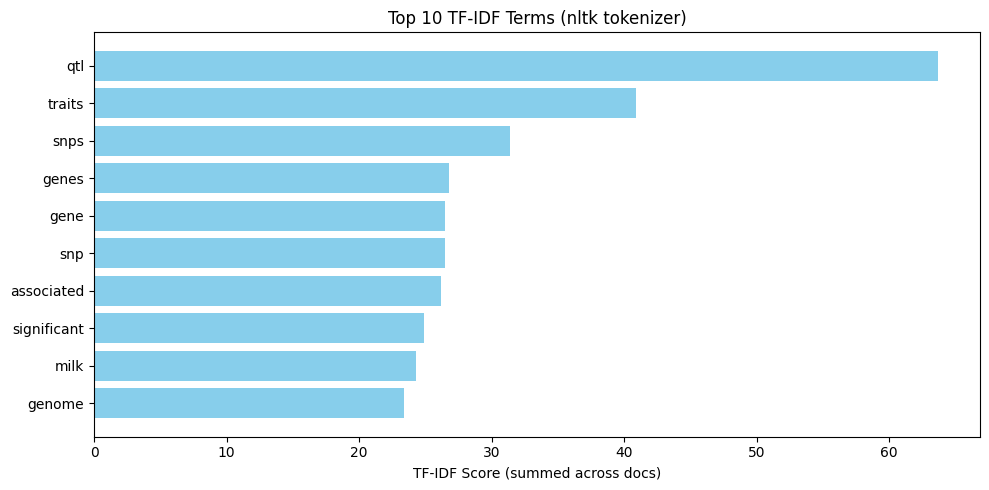

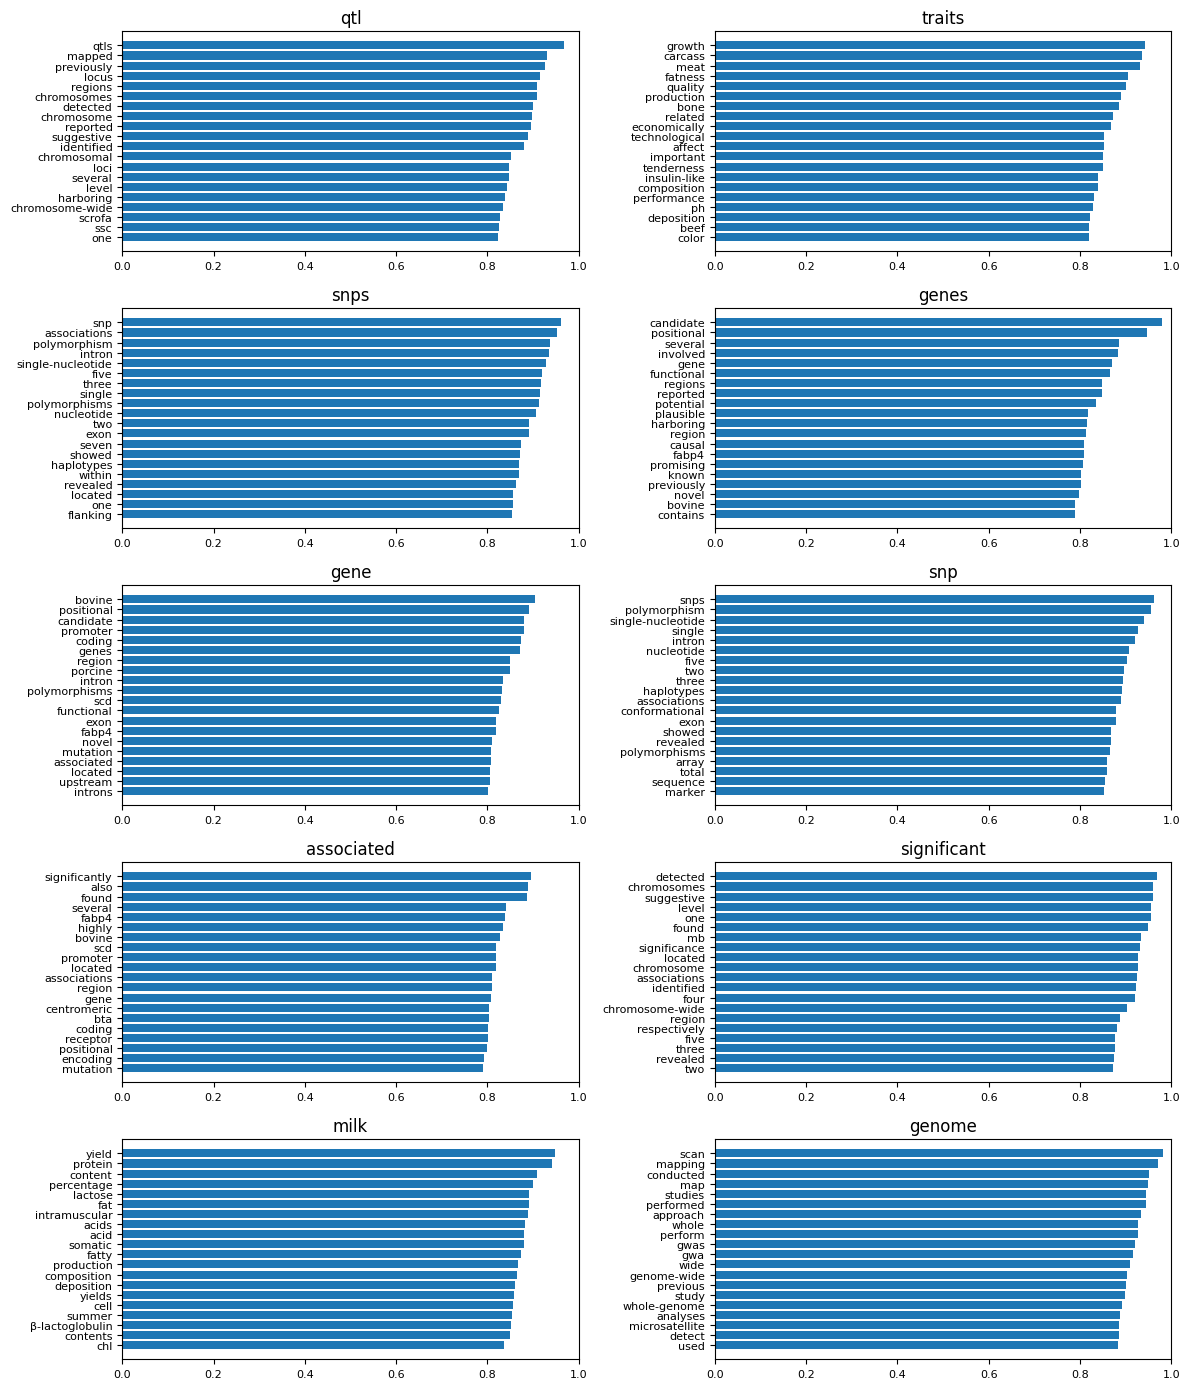

Saved bar plots to nltk_task2_bars.png
Saved report to nltk_task2_report.txt


<Figure size 640x480 with 0 Axes>

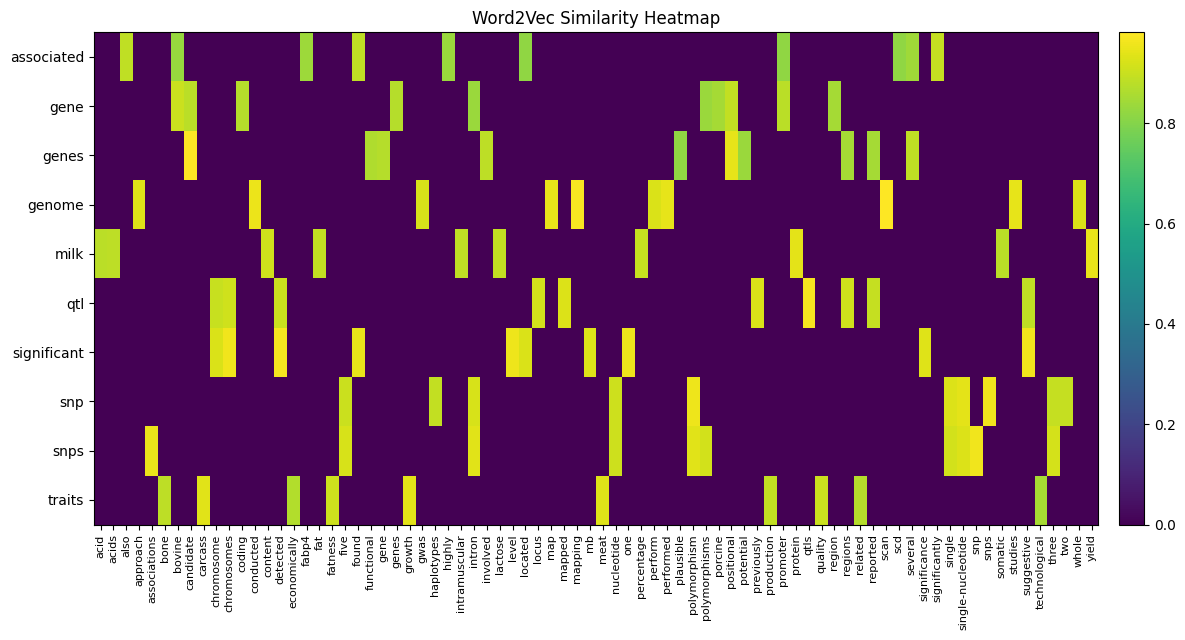

Saved heatmap to nltk_task2_heatmap.png


<Figure size 640x480 with 0 Axes>

In [31]:
task2(data,option="nltk",heatmap=True)

**spacy**

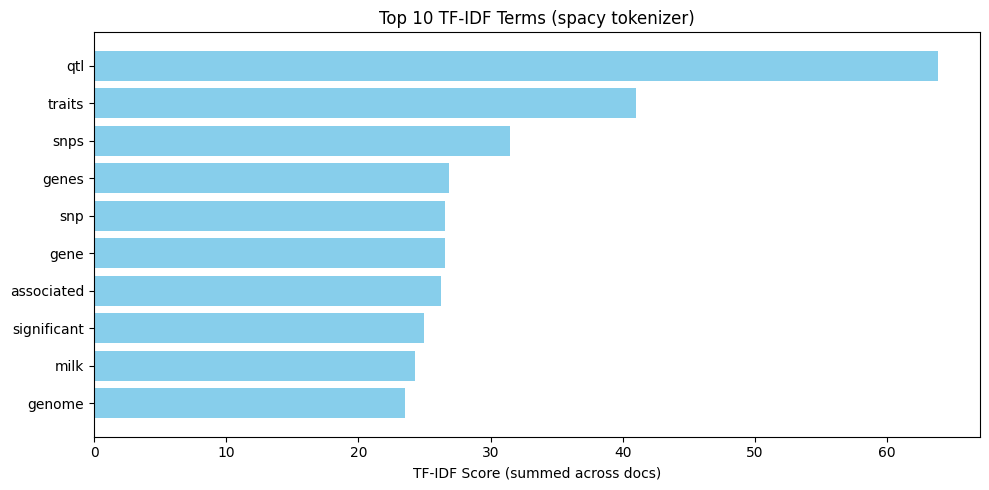

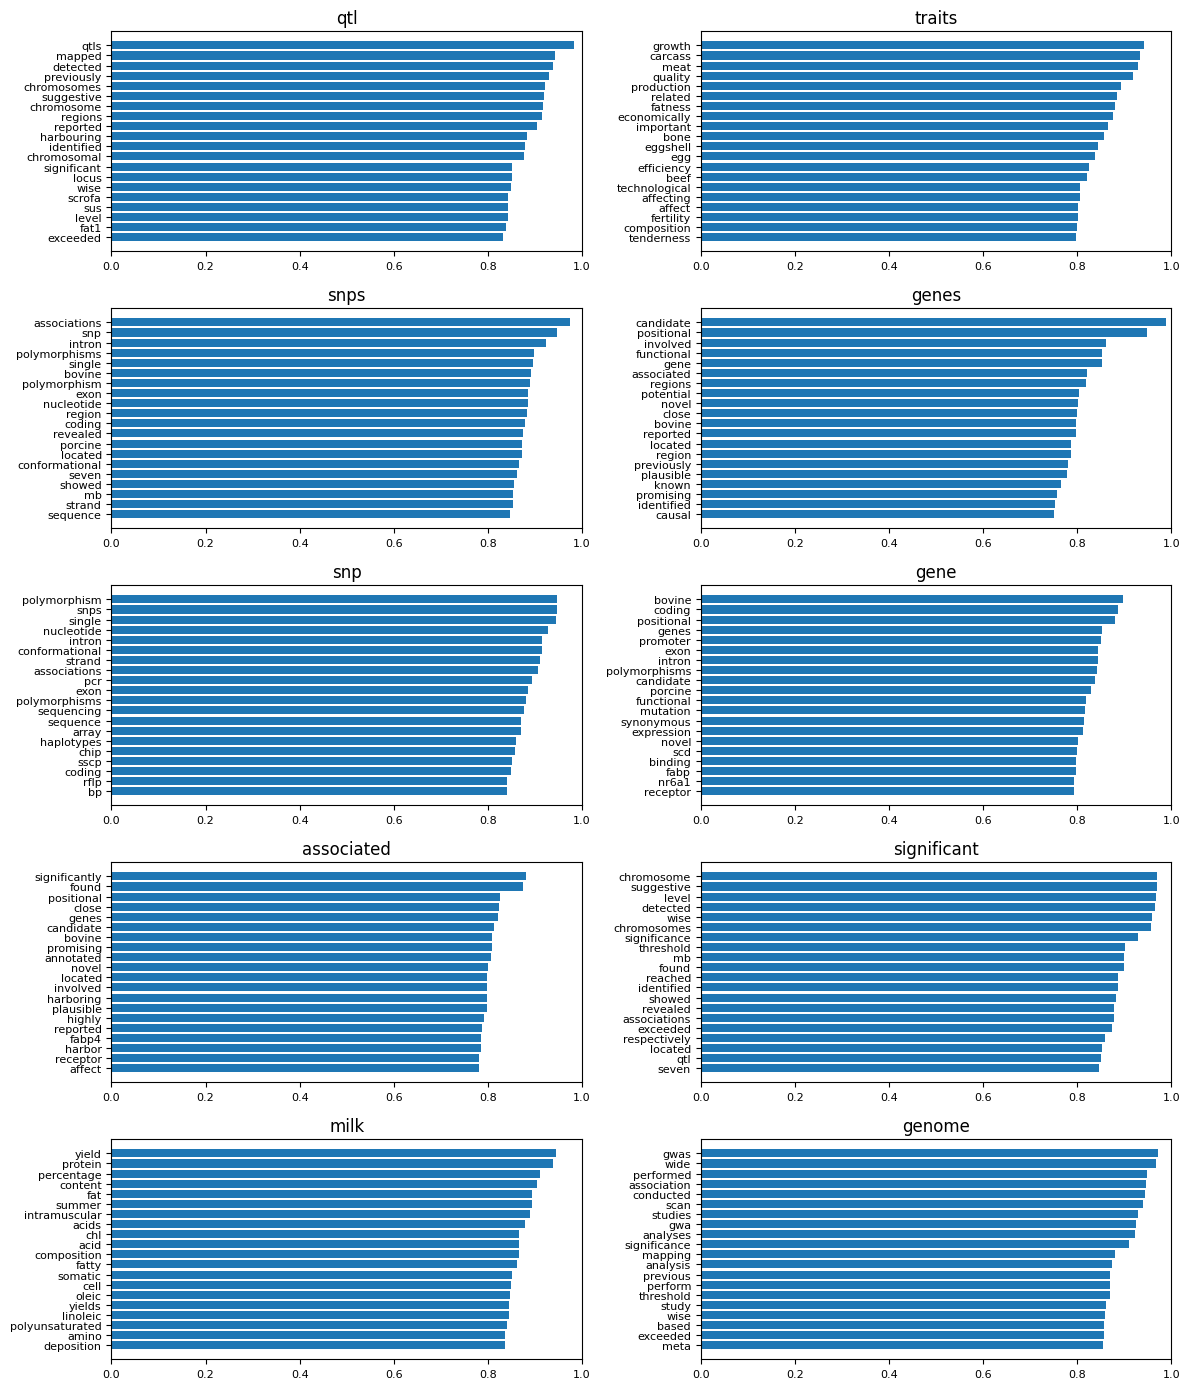

Saved bar plots to spacy_task2_bars.png
Saved report to spacy_task2_report.txt


<Figure size 640x480 with 0 Axes>

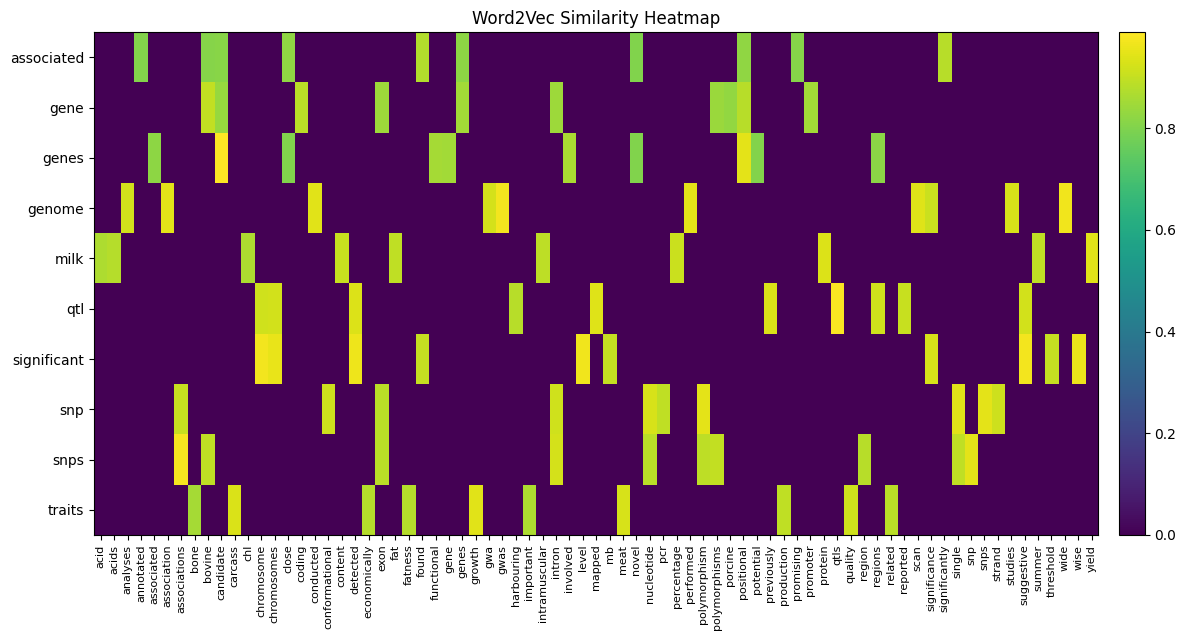

Saved heatmap to spacy_task2_heatmap.png


<Figure size 640x480 with 0 Axes>

In [32]:
task2(data,option="spacy",heatmap=True)

In [33]:
data.to_csv("upto_task2.csv",index=False)

# Task 3 : Keyword Extraction+ Repeat (Task 1+2)

**Phrase Extraction**

**n-grams**: 

[Reference](https://www.kaggle.com/code/rohitgarud/all-almost-keyword-extraction-techniques-in-nlp/notebook)

In [34]:
docs_tokens = load_tokens(data,'nltk')
docs_texts  = [" ".join(toks) for toks in docs_tokens]

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(analyzer="word",
                     ngram_range=(1, 7),
                     min_df=2,                 # tweakable: ignore very rare phrases
                     stop_words="english")
Xc = cv.fit_transform(docs_texts)
phrases = cv.get_feature_names_out()
counts = np.asarray(Xc.sum(axis=0)).ravel()
freq_dict = {phrases[i]: int(counts[i]) for i in range(len(phrases)) if counts[i] > 0}


In [36]:
import pandas as pd

with open(dictionary_path, "r", encoding="utf-8") as f:
    traits = set(line.strip().lower() for line in f if line.strip())

matches = [p for p in phrases if p in traits]

print(f"Found {len(matches)} among total {len(phrases)} phrase(s) in the trait dictionary:")
print(matches[:10])

Found 393 among total 31734 phrase(s) in the trait dictionary:
['abdominal fat', 'abdominal fat weight', 'ability', 'abnormal sperm', 'abomasum', 'adipocyte', 'adipose', 'adipose tissue', 'albumin', 'alkaline phosphatase']


Now that we have the keywords let's do step 1 and 2

Task 1 : Creating worlcloud with count and TF-IDF

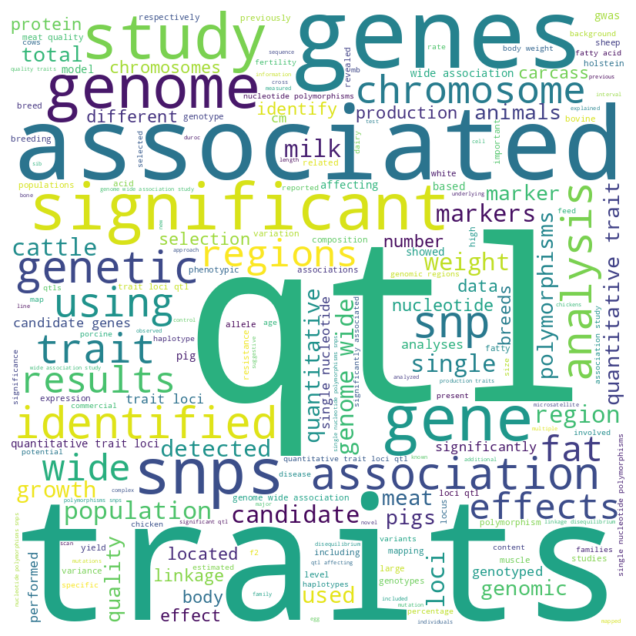

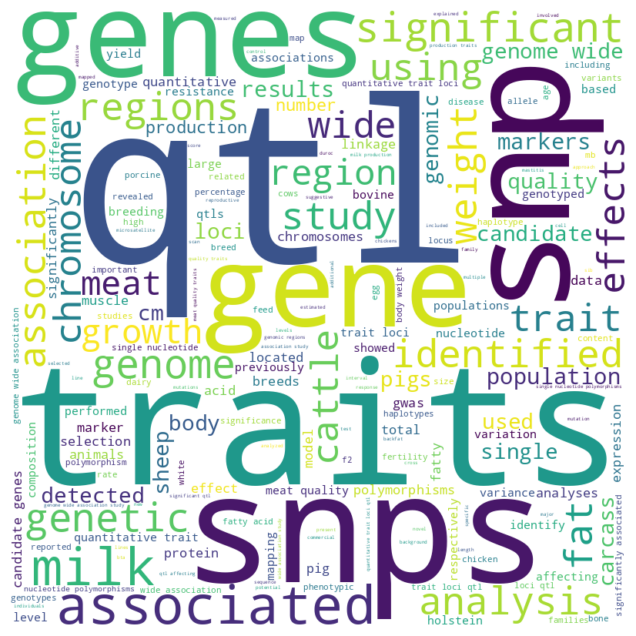

In [37]:
_draw_wc(freq_dict, "phrase_wordcloud_freq.png")

# Phrase TF-IDF (bigrams & trigrams) 
tv = TfidfVectorizer(analyzer="word",
                     ngram_range=(1, 7),
                     min_df=2,
                     stop_words="english",
                     norm=None)   # we will sum raw tf-idf weights across docs
Xt = tv.fit_transform(docs_texts)
terms = tv.get_feature_names_out()
tfidf_sum = np.asarray(Xt.sum(axis=0)).ravel()
tfidf_dict = {terms[i]: float(tfidf_sum[i]) for i in range(len(terms)) if tfidf_sum[i] > 0}

_draw_wc(tfidf_dict, "phrase_wordcloud_tfidf.png")

**Task 2**

In [38]:
def viz_w2v_sims_task3(w2v, terms, topn=15, cols=2, option="nltk",heatmap=False,save=True,save_text=True):
    """
    Visualize Word2Vec most-similar words for given terms.
    - w2v: trained gensim Word2Vec model
    - terms: list of query terms (e.g., top TF-IDF terms)
    - topn: number of neighbours to show per term
    - cols: columns for small-multiples grid
    - heatmap: if True, also renders a (terms x neighbours) heatmap
    Returns a tidy DataFrame with columns: term, similar, sim
    """
    out_prefix = f"{option}_task2"
    rows = []
    for t in terms:
        if t in w2v.wv.key_to_index:
            for w, s in w2v.wv.most_similar(t, topn=topn):
                rows.append((t, w, s))
        else:
            rows.append((t, "(not in vocab)", np.nan))

    df = pd.DataFrame(rows, columns=["term","similar","sim"])
    #display(df)

    # --- Small multiples ---
    uniq = [t for t in terms if t in w2v.wv.key_to_index] or ["(none)"]
    r = int(np.ceil(len(uniq)/cols))
    plt.figure(figsize=(6*cols, 2.8*r))
    for i, t in enumerate(uniq, 1):
        ax = plt.subplot(r, cols, i)
        d = df[df.term==t].nlargest(topn, "sim")
        ax.barh(d["similar"][::-1], d["sim"][::-1])      # default matplotlib colors
        ax.set_title(t)
        ax.set_xlim(0, 1)
        ax.tick_params(axis="both", labelsize=8)
    plt.tight_layout(); plt.show()
    if save:
        fname = f"{out_prefix}_bars.png"
        plt.savefig(fname, dpi=150, bbox_inches="tight")
        print(f"Saved bar plots to {fname}")

    if save_text:
        report_file = f"{out_prefix}_report.txt"
        with open(report_file, "w", encoding="utf-8") as f:
            f.write("Top TF-IDF terms:\n")
            f.write(", ".join(terms) + "\n\n")
            for t in terms:
                f.write(f"== {t} ==\n")
                d = df[df.term==t].nlargest(topn, "sim")
                for _, row in d.iterrows():
                    f.write(f"{row['similar']:20s} {row['sim']:.4f}\n")
                f.write("\n")
        print(f"Saved report to {report_file}")

    # --- Optional heatmap (quick overview) ---
    if heatmap and uniq and uniq[0] != "(none)":
        # Take topk per term, pivot; fill missing with 0 for display
        k = min(topn, 10)
        topk = (df[df.term.isin(uniq)]
                .sort_values(["term","sim"], ascending=[True, False])
                .groupby("term").head(k))
        piv = topk.pivot(index="term", columns="similar", values="sim").fillna(0)
        plt.figure(figsize=(min(12, 0.45*piv.shape[1]+2), 0.5*piv.shape[0]+1.5))
        plt.imshow(piv.values, aspect="auto")
        plt.yticks(range(piv.shape[0]), piv.index)
        plt.xticks(range(piv.shape[1]), piv.columns, rotation=90, fontsize=8)
        plt.title("Word2Vec Similarity Heatmap")
        plt.colorbar(fraction=0.03, pad=0.02)
        plt.tight_layout(); plt.show()
        if save:
            fname = f"{out_prefix}_heatmap.png"
            plt.savefig(fname, dpi=150, bbox_inches="tight")
            print(f"Saved heatmap to {fname}")

    return df

In [39]:
tv = TfidfVectorizer(analyzer="word",
                     ngram_range=(1,7),
                     min_df=2,
                     stop_words="english",
                     norm=None) 
Xt = tv.fit_transform(docs_texts)
terms = tv.get_feature_names_out()
weights = np.asarray(Xt.sum(axis=0)).ravel()
top_idx = weights.argsort()[::-1][:10]
top_phrases = [terms[i] for i in top_idx]
print("Top 10 TF-IDF phrases:", top_phrases, "\n")

Top 10 TF-IDF phrases: ['qtl', 'traits', 'snps', 'snp', 'genes', 'gene', 'associated', 'milk', 'significant', 'genome'] 



In [40]:
w2v = Word2Vec(
    sentences=docs_tokens,
    vector_size=100,
    window=5,
    min_count=10,
    workers=4,
    sg=0,     # CBOW
    seed=42
)
w2v.save("w2v_phrases_100d_win5_mc10.model")


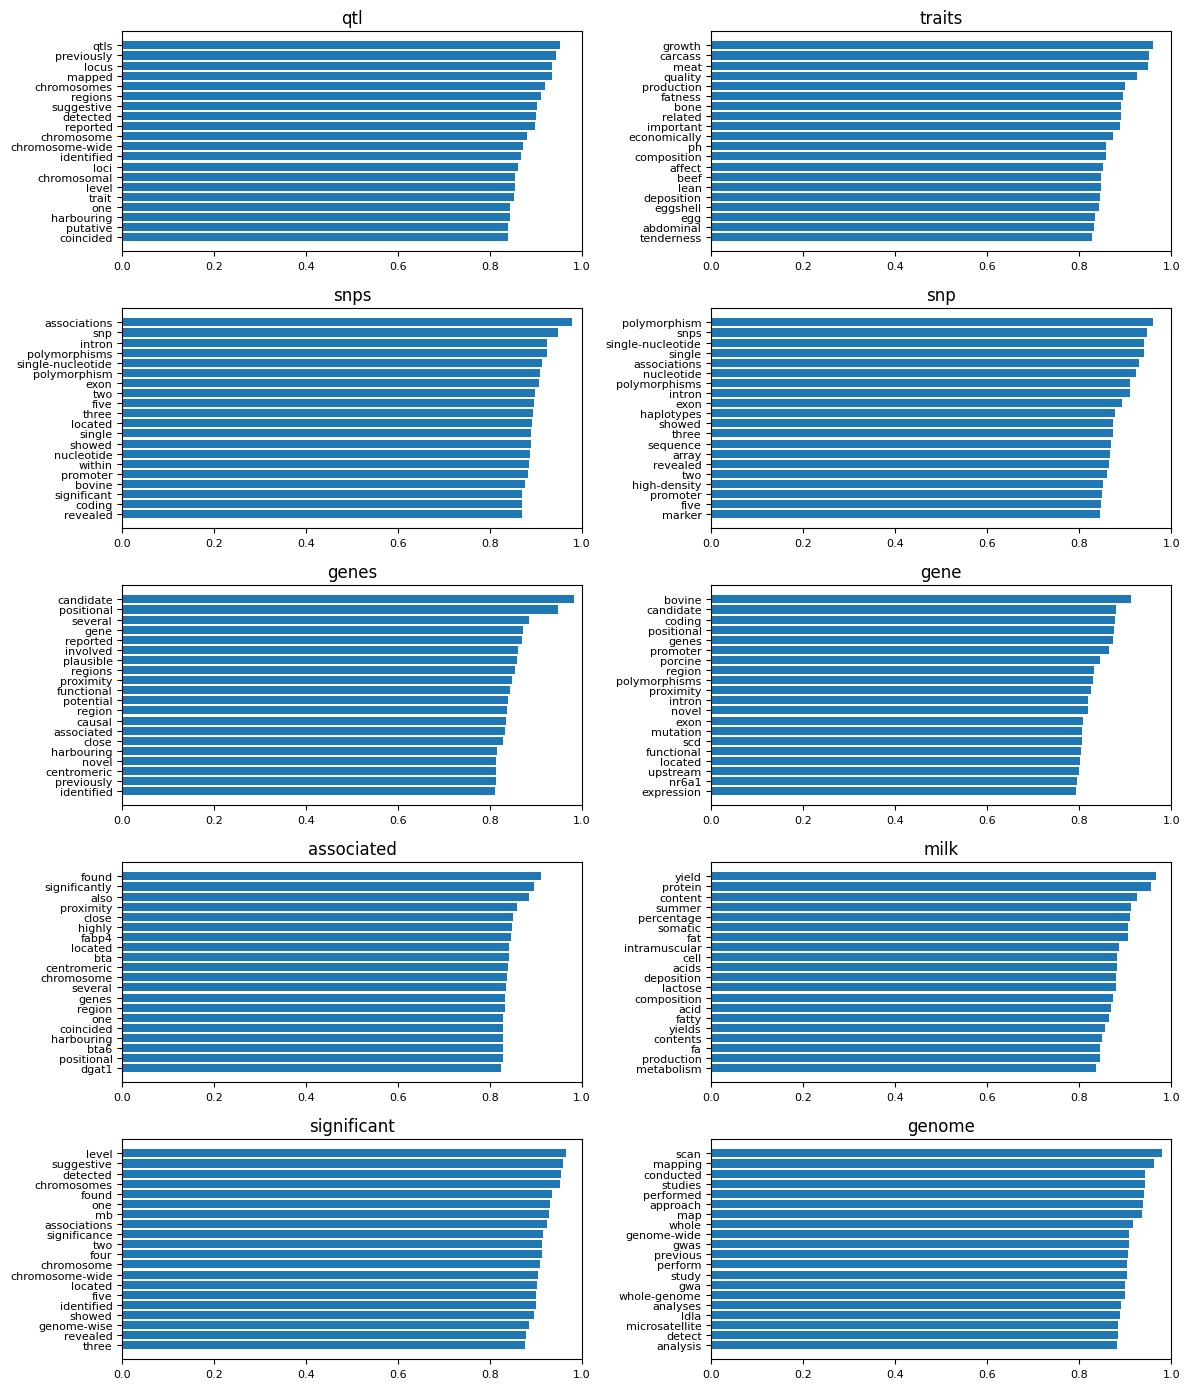

Saved bar plots to phrases_task2_bars.png
Saved report to phrases_task2_report.txt


<Figure size 640x480 with 0 Axes>

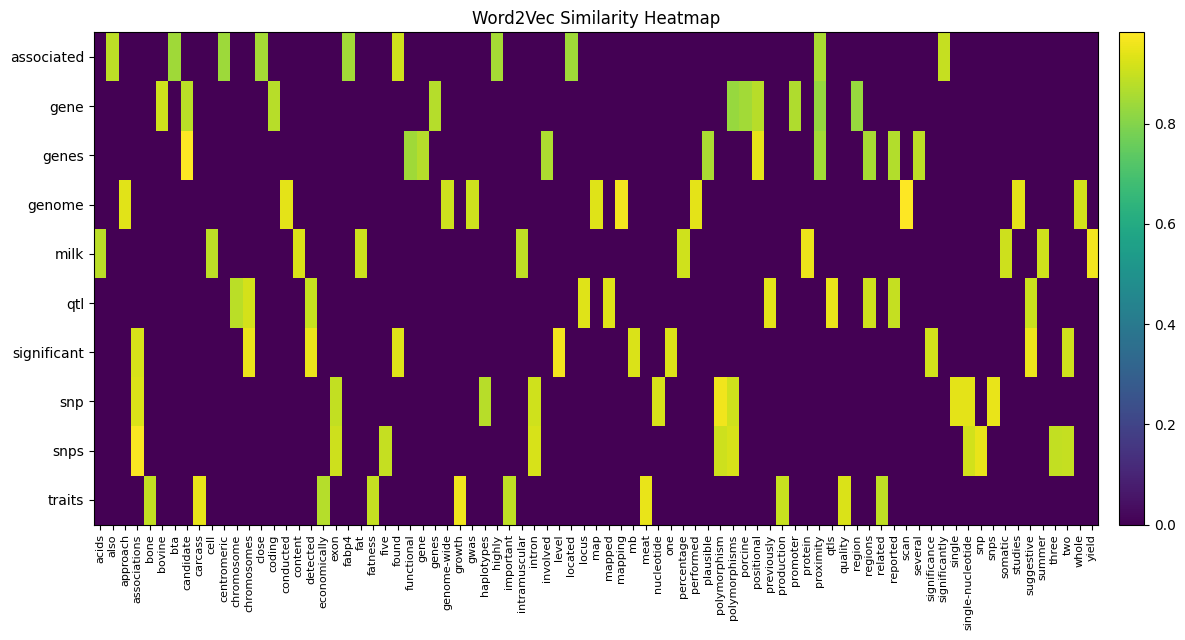

Saved heatmap to phrases_task2_heatmap.png


<Figure size 640x480 with 0 Axes>

In [41]:
df_sims = viz_w2v_sims_task3(w2v, top_phrases, topn=20, cols=2,option="phrases",save=True,heatmap=True)

# Other Phrase Extraction Techniques: 


We use three other techniques: 
1. PKE : [Python Keyphrase Extraction](https://github.com/boudinfl/pke)
2. [TextRank](https://github.com/davidadamojr/TextRank)
3. [KeyBERT](https://github.com/MaartenGr/KeyBERT)

**PKE:**

In [42]:
%%capture
!pip install git+https://github.com/boudinfl/pke.git

In [43]:

import pke
count = 0
def extract_keyphrases(caption, n=20):
    global count
    count+=1

    if count%100==0:
        print(f"{count} completed")
    extractor = pke.unsupervised.TextRank() 
    extractor.load_document(caption)
    extractor.candidate_selection()
    extractor.candidate_weighting()
    keyphrases = extractor.get_n_best(n=n, stemming=False)

    
    return [x[0] for x in keyphrases]

In [44]:
%%time
from tqdm import tqdm
from itertools import chain
data['pke_keywords'] = data['Abstract'].apply(lambda x:extract_keyphrases(x))

100 completed
200 completed
300 completed
400 completed
500 completed
600 completed
700 completed
800 completed
900 completed
1000 completed
CPU times: user 13min 10s, sys: 7.94 s, total: 13min 18s
Wall time: 13min 17s


In [45]:
from itertools import chain 
all_phrases = list(set(chain.from_iterable(data['pke_keywords'])))

matches = [p for p in all_phrases if p in traits]

print(f"Found {len(matches)} among total {len(all_phrases)} phrase(s) in the trait dictionary:")
print(matches[:10])

Found 256 among total 13103 phrase(s) in the trait dictionary:
['leaf fat weight', 'udder depth', 'parasitic infection', 'ileum length', 'sympathetic nervous system', 'femur bone mineral density', 'corpora lutea', 'spleen weight', 'shank length', 'length']


**TextRank**

In [46]:
%%capture
!pip install pytextrank

In [47]:

import spacy
import pytextrank
# load a spaCy model, depending on language, scale, etc.
nlp_textrank = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp_textrank.add_pipe("textrank")

/usr/local/lib/python3.11/dist-packages


In [48]:
%%time

def extract_keywords_textrank(text):
    try:
        doc = nlp_textrank(text)
        doc_keywords = [keyword.text for keyword in doc._.phrases if len(keyword.text.split()) <= 7]
        #deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
        final_keywords = ", ".join(doc_keywords)
        return final_keywords
    except:
        return "empty"
    
data["textRank_Keywords"] = data['Abstract'].apply(lambda x:extract_keywords_textrank(x).split(','))
all_phrases = list(set(chain.from_iterable(data["textRank_Keywords"])))

matches = [p for p in all_phrases if p in traits]

print(f"Found {len(matches)} among total {len(all_phrases)} phrase(s) in the trait dictionary:")
print(matches[:10])

Found 37 among total 37537 phrase(s) in the trait dictionary:
['platelet count', 'non-return rate', 'somatic cell score', 'semen volume', 'milk protein', 'ovulation rate', 'milk somatic cell score', 'thoracic vertebrae number', 'female fertility', 'milk fat yield']
CPU times: user 1min, sys: 198 ms, total: 1min
Wall time: 1min


In [49]:
data.to_csv("final.csv",index=False)

3. KeyBERT

KeyBERT is done in a separate notebook